<a href="https://colab.research.google.com/github/youngyoung-0/algorithms/blob/main/python_ML_study/IMDB_movie_reviews_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 영화평 Text 분류 - Sentiment Analysis
* IMDB dataset
* 각 25,000개의 training / testing set 으로 구성된 IMDB 영화관람평
* "imdb_reviews" - encoding 되어 있지않은 string 형태의 data
* label : positive,negative binary classification

In [74]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# 시드 설정
seed_value = 42
tf.random.set_seed(seed_value)

In [75]:
# imdb_reviews 데이터셋을 로드하고, 정보(info)와 함께 로드(as_supervised=True는 (input, label) 쌍으로 로드)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
dataset
# 데이터 셋을 훈령용, 테스트용으로 분할
train_dataset, test_dataset = dataset['train'], dataset['test']

print(info)
print()
print(train_dataset)
print()
print(test_dataset)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_e

In [76]:
len(train_dataset), len(test_dataset)

(25000, 25000)

In [77]:
# tfds는 tf.Tensor 반환
for input, label in dataset['test']:
  print(input)
  print(label)
  break

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

### Keras.preprocessing module을 이용하여 tokenize 및 padding
* keras.preprocessing.text.Tokenizer
* keras.preprocessing.sequence.pad_sequence

In [78]:
# 훈련용 문장과 레이블을 저장할 리스트 초기화
train_sentences = []
train_labels = []

# 테스트용 문장과 레이블을 저장할 리스트 초기화
test_sentences = []
test_labels = []

# 훈련 데이터셋의 각 (문장, 레이블) 쌍에 대해 반복
for sent, label in train_dataset:
  train_sentences.append(str(sent.numpy))
  train_labels.append(label.numpy())

# 테스트 데이터세싀 각 (문장, 레이블) 쌍에 대해 반복
for sent, label in test_dataset:
  test_sentences.append(str(sent.numpy))
  test_labels.append(label.numpy())

print(train_labels[-1])   # 훈련 데이터셋의 마지막 레이블 출력
print(train_sentences[-1])    # 훈련 데이터셋의 마지막 문장 출력

print(test_labels[-1])    # 테스트 데이터셋의 마지막 레이블 출력
print(test_sentences[-1])    # 테스트 데이터셋의 마지막 문장 출력

1
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=string, numpy=b'First of all, Riget is wonderful. Good comedy and mystery thriller at the same time. Nice combination of strange \'dogma\' style of telling the story together with good music and great actors. But unfortunately there\'s no \'the end\'. As for me it\'s unacceptable. I was thinking... how it will be possible to continue the story without Helmer and Drusse? ...and I have some idea. I think Lars should make RIGET III a little bit different. I\'m sure that 3rd part without Helmer wouldn\'t be the same. So here\'s my suggestion. Mayble little bit stupid, maybe not. I know that Lars likes to experiment. So why not to make small experiment with Riget3? I think the only solution here is to create puppet-driven animation (like for example "team America" by Trey Parker) or even computer 3d animation. I know it\'s not the same as real actors, but in principle I believe it could work... only this way it\'s possibl

### train_labels, test_labels list를 numpy array로 변환

In [79]:
# 사용할 단어 수의 최대 크기 설정
vocab_size = 10000

# Tokenizer 객체 생성 (최대 단어 수 지정 및 OOV(Out-Of-Vocabulary) 토큰 설정)
tokenizer = Tokenizer(num_words = vocab_size, oov_token='<OOV>')

# 훈련 문장에 대해 토크나이저 학습 수행 (단어 인덱스 구축)
tokenizer.fit_on_texts(train_sentences)

In [80]:
# 훈련 문장들을 시퀀스로 변환
train_sequences = tokenizer.texts_to_sequences(train_sentences)

# 테스트 문장들을 시퀀스로 변환
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# 첫 번째 훈련 시퀀스 출력
print(train_sentences[0])

# 첫 번째 테스트 시퀀스 출력
print(test_sequences[0])

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">>
[32, 35, 36, 14, 3, 37, 38, 33, 39, 34, 14, 68, 53, 26, 118, 13, 106, 4121, 17, 751, 4375, 10, 15, 325, 3, 2, 602, 363, 17, 1873, 1221, 1, 17, 689, 7504, 5600, 1, 782, 6, 13, 1046, 1, 1, 448, 500, 1, 5, 

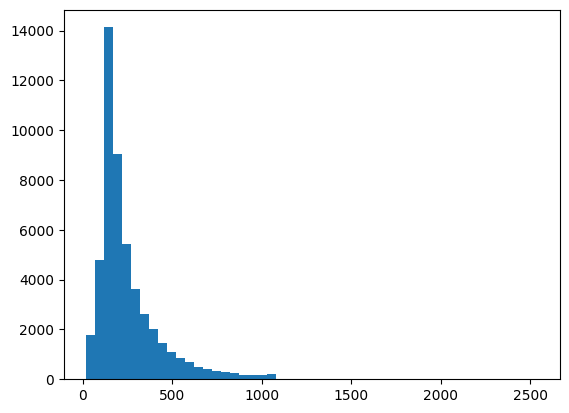

In [81]:
# 훈련 시퀀스와 테스트 시퀀스의 길이를 리스트로 변환하여 합친 후 히스토그램으로 시각화
plt.hist([len(s) for s in train_sequences] + [len(s) for s in test_sequences], bins=50);

In [82]:
max_length = 150

# 훈련 시퀀스를 패딩 처리 (최대 길이를 150으로 설정, 'post' 방식으로 잘라내고 패딩)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')

# 테스트 시퀀스를 패딩 처리 (최대 길이를 150으로 설정, 'post' 방식으로 잘라내고 패딩)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# 첫 번째 훈련 패딩된 시퀀스 출력
print(train_padded[0])
print(test_padded[0])
print(len(train_dataset))

[  32   35   36   14    3   37   38   33   39   34   14   68   12   15
   44  448  409   19  183   30    1    9   42 1387 3408   51  505    1
  206   26   97  165   20   12  220  349   30   79  257  222    9  495
   71   79   97  125  108   25 5745   12 3324  666  786   12   19    7
   44  415 8233  187 2486  435    2  101 1262  149   81  158   64    2
    1 7530   81  238   79 2970   17    1 2888    1    1 1515 5003    4
   49 3953  128 1617   18 3408   15  172   20    5 1262  936 7991    9
    5   19   13   15 4206    3  111  157 1246   11  249  701   13   53
   26  110   48   12 7237    1   48 1387    1   61  418   11  108 1223
  883  154   10    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[  32   35   36   14    3   37   38   33   39   34   14   68   53   26
  118   13  106 4121   17  751 4375   10   15  325    3    2  602  363
   17 1873 1221    1   17  689 7504 5600    1  782    6   13 1046    1
    1  448  500    1    5

In [83]:
# 단어 인덱스를 키로, 단어 갑스로 하는 사전 생성
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

# 시퀀스를 리뷰 텍스트로 디코딩하는 함수
def decode_review(sequences):
  # 시퀀스의 각 인덱스를 단어로 변환하여 리스트로 만들고, 이를 공백으로 연결하여 문자열로 반환
  return ' '.join([reverse_word_index.get(idx, '<pad>') for idx in sequences])

# 첫 번째 훈련 패딩된 시퀀스를 디코딩하여 출력
print(decode_review(train_padded[0]))
print()

# 첫 번째 훈련 문장 원본 출력
print(train_sentences[0])


bound method eagertensorbase numpy of tf tensor shape dtype string numpy b this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining <OOV> like christopher <OOV> good name i could barely sit through it <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie.

### model define


In [84]:
# model = Sequential()
# model.add(Embedding(vocab_size + 1, 64))
# model.add(Bidirectional(LSTM(64)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()

In [85]:
model = Sequential([
    Embedding(vocab_size + 1, 64),         # 임베딩 레이어 추가 (어휘 크기 + 1, 임베딩 차원 64)
    Bidirectional(tf.keras.layers.LSTM(64)),     # 양방향 LSTM 레이어 추가 (유닛 수 64)
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [86]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.build(input_shape=(None, max_length)) # Explicitly building the model is often not needed
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [87]:
num_epochs = 30
history = model.fit(train_padded, np.array(train_labels), epochs=num_epochs, batch_size=128, validation_data=(test_padded, np.array(test_labels)), verbose=1)

Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 125s 604ms/step - accuracy: 0.6071 - loss: 0.6382 - val_accuracy: 0.8065 - val_loss: 0.4354
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 146s 626ms/step - accuracy: 0.8631 - loss: 0.3387 - val_accuracy: 0.8142 - val_loss: 0.4586
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 122s 623ms/step - accuracy: 0.9025 - loss: 0.2570 - val_accuracy: 0.7784 - val_loss: 0.5379
Epoch 4/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 118s 604ms/step - accuracy: 0.8997 - loss: 0.2640 - val_accuracy: 0.8098 - val_loss: 0.5013
Epoch 5/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 120s 614ms/step - accuracy: 0.9162 - loss: 0.2224 - val_accuracy: 0.8032 - val_loss: 0.5189
Epoch 6/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 126s 645ms/step - accuracy: 0.9362 - loss: 0.1836 - val_accuracy: 0.8184 - val_loss: 0.5107
Epoch 7/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 117s 598ms/step - accuracy: 0.9281 - loss: 0.2013 - val_accuracy: 0.8165 - val_loss: 0.4952
Epoch 8/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 119s 609ms/step - accuracy: 0.9341 -

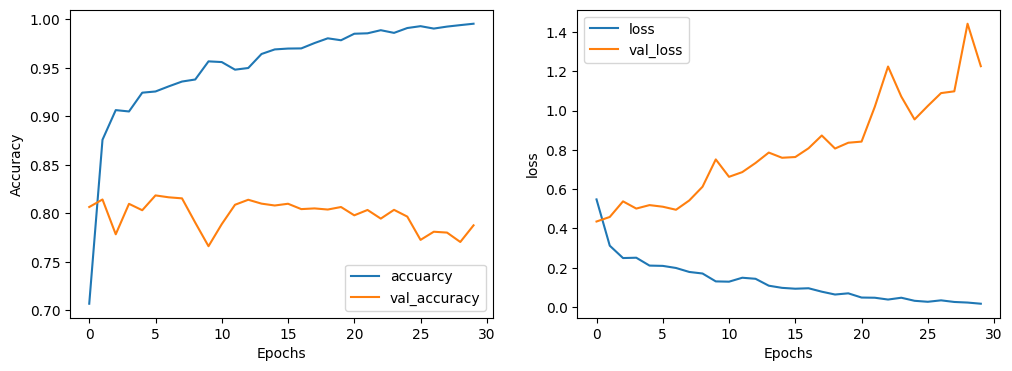

In [90]:
fig, (ax1, ax2)  = plt.subplots(1,2,figsize=(12,4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])


ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])

In [91]:
sample_text = ['The movei was terrible. I would not recommend the movie']
# sample_text = ['The movei was fantastic. I would recommend the movie']
# sample_text = ['The animation and graphics were out of this world']
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post', truncating='post')
sample_padded

array([[  2,   1,  15, 409,  11,  73,  25, 401,   2,  19,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [92]:
model.predict([sample_padded])

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_20
Received: inputs=('Tensor(shape=(1, 150))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


array([[0.19640286]], dtype=float32)